In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean_location.xlsx')
df['Location'] = df['Location'].str.strip()
df.loc[df['Location'].eq('Faro') & df['Screening_date'].eq('2022-08-13'), 'Screening_date'] = '2022-08-14'
df.loc[df['Location'].eq('Lisboa') & df['Screening_date'].eq('2023-05-15'), 'Screening_date'] = '2023-05-19'

df.head()

d1 = df.groupby(['Location', 'Screening_date'], as_index=False).size().sort_values(['Location', 'Screening_date'])
d2 = d1.assign(count = d1.groupby(['Location'])['Location'].transform('count'))
d2 = d2[d2['count'].ne(1)]

d2['ndays'] = d2.groupby('Location')['Screening_date'].diff()
d2['nscreens'] = d2['size'].values/d2['ndays'].dt.days
d2

date_range = pd.date_range(start='2022-03-03', end='2024-04-20') #datas mais extremas no dataset

datesdf = pd.DataFrame(date_range, columns=['Screening_date'])

list_dfs = []

groups = d2.groupby('Location')

for _, group in groups:
    list_dfs.append(datesdf.merge(group, how='left').bfill().ffill())

d3 = pd.concat(list_dfs)
d3

# Agrupar por 'Screening_date' e calcular a soma de 'nscreens' para cada data (ou use outra função agregada como média)
d4 = d3.groupby('Screening_date', as_index=False)['nscreens'].sum()

d4


,Screening_date,nscreens
0,2022-03-03,11.169861
1,2022-03-04,11.169861
2,2022-03-05,11.169861
3,2022-03-06,11.169861
4,2022-03-07,11.169861
...,...,...
775,2024-04-16,12.874846
776,2024-04-17,12.874846
777,2024-04-18,12.874846
778,2024-04-19,12.874846


In [3]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Supondo que 'd4' já foi criado conforme você descreveu

# 1. Realizar o teste ADF para verificar a estacionaridade
result = adfuller(d4['nscreens'])

# 2. Extrair e imprimir os resultados
adf_statistic = result[0]
p_value = result[1]
used_lag = result[2]
n_observations = result[3]
critical_values = result[4]

print('\nResultados do teste ADF:')
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Used Lag:', used_lag)
print('Number of Observations:', n_observations)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# 3. Interpretação dos resultados
if p_value < 0.05:
    print("Rejeitamos a hipótese nula: a série é estacionária.")
else:
    print("Não rejeitamos a hipótese nula: a série não é estacionária.")



Resultados do teste ADF:
ADF Statistic: -1.1583735563439237
p-value: 0.6912413038161388
Used Lag: 0
Number of Observations: 779
Critical Values:
   1%: -3.4387723094153286
   5%: -2.8652573313919625
   10%: -2.5687494684274794
Não rejeitamos a hipótese nula: a série não é estacionária.


In [4]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Realizar o teste ADF na coluna 'nscreens' do DataFrame 'd4'
result = adfuller(d4['nscreens'])

# Extrair resultados do teste
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Imprimir resultados
print('\nResultados do teste ADF:')
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Valores Críticos:', critical_values)

# Interpretação
if p_value < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")



Resultados do teste ADF:
ADF Statistic: -1.1583735563439237
p-value: 0.6912413038161388
Valores Críticos: {'1%': -3.4387723094153286, '5%': -2.8652573313919625, '10%': -2.5687494684274794}
A série não é estacionária.


In [7]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Supondo que 'd4' já foi criado e contém a coluna 'nscreens'

# Aplicar diferenciação
d4['nscreens_diff'] = d4['nscreens'].diff()

# Remover NaN que podem surgir da diferenciação
d4 = d4.dropna()

# Realizar o teste ADF na nova série 'nscreens_diff'
result = adfuller(d4['nscreens_diff'])

# 2. Extrair e imprimir os resultados
adf_statistic = result[0]
p_value = result[1]
used_lag = result[2]
n_observations = result[3]
critical_values = result[4]

print('\nResultados do teste ADF:')
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Used Lag:', used_lag)
print('Number of Observations:', n_observations)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# 3. Interpretação dos resultados
if p_value < 0.05:
    print("Rejeitamos a hipótese nula: a série é estacionária.")
else:
    print("Não rejeitamos a hipótese nula: a série não é estacionária.")



Resultados do teste ADF:
ADF Statistic: -27.82622137870492
p-value: 0.0
Used Lag: 0
Number of Observations: 776
Critical Values:
   1%: -3.438804978547988
   5%: -2.8652717302548396
   10%: -2.5687571389759802
Rejeitamos a hipótese nula: a série é estacionária.


In [5]:
max_value = d4['nscreens'].max()
print(max_value)


12.874845651448748


: 

# LR MODEL

In [3]:
# Supondo que o DataFrame 'df' já esteja carregado com as colunas 'Screening_date' e 'nscreens'
d4['Screening_date'] = pd.to_datetime(d4['Screening_date'])

# Converter 'Screening_date' para número de dias desde a data mínima
d4['days_since_start'] = (d4['Screening_date'] - d4['Screening_date'].min()).dt.days

In [36]:
d4

,Screening_date,nscreens,days_since_start
0,2022-03-03,11.169861,0
1,2022-03-04,11.169861,1
2,2022-03-05,11.169861,2
3,2022-03-06,11.169861,3
4,2022-03-07,11.169861,4
...,...,...,...
775,2024-04-16,12.874846,775
776,2024-04-17,12.874846,776
777,2024-04-18,12.874846,777
778,2024-04-19,12.874846,778


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Definir X como 'days_since_start' e y como 'nscreens'
X = d4['days_since_start'].values.reshape(-1, 1)
y = d4['nscreens'].values

In [6]:
# Dividir os dados em conjuntos de treinamento e teste (80% treinamento e 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [39]:
# Ajustar o modelo de Regressão Linear ao conjunto de treinamento
model = LinearRegression()
model.fit(X_train, y_train)

# Gerar previsões para o conjunto de teste
y_pred = model.predict(X_test)

In [40]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: LR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: LR shuffle
# MAE: 3.0452899244104197
# MSE: 13.792722910901267
# RMSE: 3.7138555317757405
# R2: -2.636951405291359
# ME: 3.0452899244104197
# MAV: 11.228988121444878
# MPV: 0.2441679433808033
# RME: 0.2441679433808033
# RMAE: 0.2441679433808033

Modelo: LR
MAE: 3.0452899244104197
MSE: 13.792722910901267
RMSE: 3.7138555317757405
R2: -2.636951405291359
ME: 3.0452899244104197
MAV: 11.228988121444878
MPV: 0.2441679433808033
RME: 0.2441679433808033
RMAE: 0.2441679433808033


In [41]:
# Definir X como 'days_since_start' e y como 'nscreens'
X = d4['days_since_start'].values.reshape(-1, 1)
y = d4['nscreens'].values

# Converter a coluna de data para o formato datetime, se ainda não estiver nesse formato
d4['Screening_date'] = pd.to_datetime(d4['Screening_date'])

# Definir a data de corte
split_date = pd.to_datetime('2024-03-01')

# Separar o dataset em treino e teste
train_data = d4[d4['Screening_date'] < split_date]
test_data = d4[d4['Screening_date'] >= split_date]

# Definir X e y para o conjunto de treino
X_train = train_data['days_since_start'].values.reshape(-1, 1)
y_train = train_data['nscreens'].values

# Definir X e y para o conjunto de teste
X_test = test_data['days_since_start'].values.reshape(-1, 1)
y_test = test_data['nscreens'].values

In [43]:
# Treinar o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Calcular e imprimir as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: LR")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: LR split date
# MAE: 3.7142565243426153
# MSE: 13.79678381467565
# RMSE: 3.7144022149836773
# R2: -4.372375320973177e+30
# ME: 3.7142565243426153
# MAV: 12.874845651448746
# MPV: 0.2884894021175833
# RME: 0.2884894021175833
# RMAE: 0.2884894021175833

Modelo: LR
MAE: 3.7142565243426153
MSE: 13.79678381467565
RMSE: 3.7144022149836773
R2: -4.372375320973177e+30
ME: 3.7142565243426153
MAV: 12.874845651448746
MPV: 0.2884894021175833
RME: 0.2884894021175833
RMAE: 0.2884894021175833


# LSTM MODEL

In [7]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

# Normalização dos dados da coluna 'nscreens'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(d4['nscreens'].values.reshape(-1, 1))

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir o tamanho da sequência (por exemplo, 10 dias)
seq_length = 7
X, y = create_sequences(scaled_data, seq_length)

# Dividir em conjuntos de treino e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0797 - val_loss: 0.0258
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0193
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0228
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0207
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0202
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0207
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0201
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0201
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0201
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0199
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0201
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8272e-04 - val_loss: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Modelo: LSTM
MAE: 0.11717208185219818
MSE: 0.33863664634657764
RMSE: 0.5819249490669546
R2: 0.9104699094832556
ME: 0.11578682865341078
MAV: 11.2438539313933
MPV: 0.009124663507374167
RME: 0.008969449370739846
RMAE: 0.009124663507374167


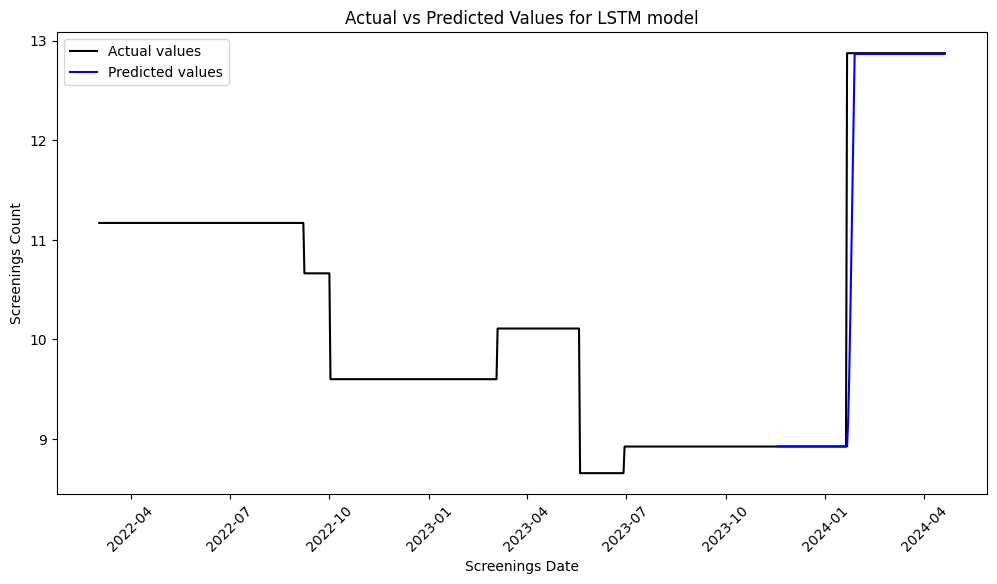

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt


# Fazer previsões no conjunto de teste
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_original = scaler.inverse_transform(y_test)

# Avaliar o modelo
mae = mean_absolute_error(y_test_original, predicted)
mse = mean_squared_error(y_test_original, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, predicted)
me = np.mean(y_test_original - predicted)
mav = np.mean(np.abs(y_test_original))
mpv = np.mean(np.abs((y_test_original - predicted) / y_test_original))
rme = np.mean((y_test_original - predicted) / y_test_original)
rmae = np.mean(np.abs(y_test_original - predicted) / np.abs(y_test_original))

print("Modelo: LSTM")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: LSTM shuffle
# MAE: 0.16014973584370207
# MSE: 0.33738311706745655
# RMSE: 0.5808468964085601
# R2: 0.9108013224919652
# ME: 0.060484750160230964
# MAV: 11.2438539313933
# MPV: 0.01255916838360269
# RME: 0.004577696164292376
# RMAE: 0.01255916838360269


# Recuperar as datas associadas ao conjunto de teste
dates_test = d4['Screening_date'].values[-len(y_test):]

# Plotando os valores reais vs. previsões ao longo do tempo
plt.figure(figsize=(12, 6))
plt.plot(d4['Screening_date'], d4['nscreens'], color='black', label='Actual values')
plt.plot(dates_test, predicted, color='blue', label='Predicted values')
plt.title('Actual vs Predicted Values for LSTM model')
plt.xlabel('Screenings Date')
plt.ylabel('Screenings Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Normalização dos dados da coluna 'nscreens'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(d4['nscreens'].values.reshape(-1, 1))

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir o tamanho da sequência (por exemplo, 7 dias)
seq_length = 7
X, y = create_sequences(scaled_data, seq_length)

# Configuração da validação cruzada com preservação da sequência temporal
tscv = TimeSeriesSplit(n_splits=5)

# Variáveis para armazenar as previsões e valores reais de todos os folds de TESTE
all_y_test_inv = []
all_y_pred_inv = []

# Iteração sobre os splits de treinamento e teste
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}")

    # Dividindo os dados de treino e teste mantendo a sequência temporal
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Construir o modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinamento do modelo
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Inverter a normalização para calcular as métricas no mesmo espaço dos dados originais
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Armazenar apenas as previsões e os valores reais de TESTE
    all_y_test_inv.extend(y_test_inv.flatten())
    all_y_pred_inv.extend(y_pred_inv.flatten())

# Convertendo as listas acumuladas para arrays numpy
all_y_test_inv = np.array(all_y_test_inv)
all_y_pred_inv = np.array(all_y_pred_inv)

# Calcular as métricas globais apenas nos dados de TESTE
total_r2 = r2_score(all_y_test_inv, all_y_pred_inv)
total_mae = mean_absolute_error(all_y_test_inv, all_y_pred_inv)
total_rmse = np.sqrt(mean_squared_error(all_y_test_inv, all_y_pred_inv))

print(f"Total - R2: {total_r2:.4f}, MAE: {total_mae:.4f}, RMSE: {total_rmse:.4f}")

Fold 1
Epoch 1/20


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.4061 - val_loss: 0.1279
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2036 - val_loss: 0.0366
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0530 - val_loss: 0.0118
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0084 - val_loss: 0.0483
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0248 - val_loss: 0.0157
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.8878e-04 - val_loss: 0.0072
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.3532e-04 - val_loss: 0.0138
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.9567e-04 - val_loss: 0.0159
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0121
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7382e-05 - val_loss: 0.

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1656 - val_loss: 0.0013
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - val_loss: 0.0190
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - val_loss: 0.0015
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0078
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 9.9466e-04
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 7.9163e-04
Epoc

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1490 - val_loss: 0.0204
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128 - val_loss: 0.0163
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - val_loss: 0.0151
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0131
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0090
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0066
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4272e-04 - val_loss: 0.0041
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8101e-04 - val_loss: 0.0038
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8137e-04 - val_loss: 0.0036
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9038e-04 - val_loss: 0.0039
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 -

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1007 - val_loss: 0.0403
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - val_loss: 0.0064
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 6.3837e-05
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 1.5302e-06
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 6.1532e-05
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 1.1629e-04
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 4.6478e-05
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 1.0586e-05
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 5.5599e-06
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_loss: 6.4347e-05
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0798 - val_loss: 0.0285
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_loss: 0.0245
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0321
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0266
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0248
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0251
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - val_loss: 0.0251
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0242
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 0.0245
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4974e-04 - val_loss: 0.0239
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0234
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 0.

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Normalização dos dados da coluna 'nscreens'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(d4['nscreens'].values.reshape(-1, 1))

# Função para criar sequências de dados
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Definir o tamanho da sequência (por exemplo, 7 dias)
seq_length = 7
X, y = create_sequences(scaled_data, seq_length)

# Configuração da validação cruzada com preservação da sequência temporal
tscv = TimeSeriesSplit(n_splits=5)

# Listas para armazenar as métricas de cada fold
r2_scores = []
mae_scores = []
rmse_scores = []

# Iteração sobre os splits de treinamento e teste
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}")

    # Dividindo os dados de treino e teste mantendo a sequência temporal
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Construir o modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinamento do modelo
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)

    # Inverter a normalização para calcular as métricas no mesmo espaço dos dados originais
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    # Calcular as métricas para este fold
    fold_r2 = r2_score(y_test_inv, y_pred_inv)
    fold_mae = mean_absolute_error(y_test_inv, y_pred_inv)
    fold_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    # Armazenar as métricas deste fold
    r2_scores.append(fold_r2)
    mae_scores.append(fold_mae)
    rmse_scores.append(fold_rmse)

    print(f"Fold {fold + 1} - R2: {fold_r2:.4f}, MAE: {fold_mae:.4f}, RMSE: {fold_rmse:.4f}")

# Calcular as métricas médias e desvio padrão
mean_r2 = np.mean(r2_scores)
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)

std_r2 = np.std(r2_scores)
std_mae = np.std(mae_scores)
std_rmse = np.std(rmse_scores)

print(f"Average - R2: {mean_r2:.4f} ± {std_r2:.4f}, MAE: {mean_mae:.4f} ± {std_mae:.4f}, RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")


Fold 1
Epoch 1/20


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.3393 - val_loss: 0.1035
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1623 - val_loss: 0.0224
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0294 - val_loss: 0.0212
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0179 - val_loss: 0.0370
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0157 - val_loss: 0.0090
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.3117e-04 - val_loss: 0.0063
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5383e-04 - val_loss: 0.0136
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 0.0128
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.4510e-04 - val_loss: 0.0093
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0397e-04 - val_loss: 0.

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.2103 - val_loss: 9.6515e-04
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - val_loss: 0.0291
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - val_loss: 0.0025
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - val_loss: 0.0035
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - val_loss: 0.0108
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 13

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1273 - val_loss: 0.0366
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - val_loss: 0.0111
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0160
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - val_loss: 0.0086
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0078
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0049
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.9718e-04 - val_loss: 0.0040
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6325e-04 - val_loss: 0.0036
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1132e-04 - val_loss: 0.0036
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5088e-04 - val_loss: 0.0036
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.6

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1013 - val_loss: 0.0438
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0065
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 2.2768e-04
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 7.8121e-08
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 9.3017e-05
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 9.4336e-05
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 4.9622e-05
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 3.2767e-05
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 4.8500e-05
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 5.9044e-05
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0614 - val_loss: 0.0444
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0242
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0262
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0775e-04 - val_loss: 0.0233
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0235
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0236
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0235
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0232
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0232
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.6054e-04 - val_loss: 0.0231
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9564e-04 - val_loss: 0.0232
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_